## Programming Assignment 5
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion.

### Task 1
#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object
#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [39]:
from scipy.io import loadmat
x = loadmat('teapot.mat')

In [40]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

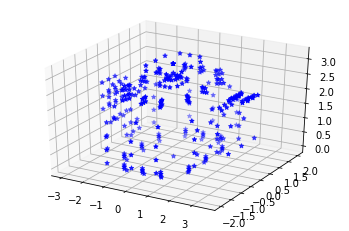

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')

In [42]:
import numpy as np
import math

In [43]:
### Your implementation comes here
intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

#    cos  0  sin
#     0   1   0
#   -sin  0  cos
# Rotation along y-axis

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([
        [math.cos(rot_angle), 0, math.sin(rot_angle), 0], 
        [0, 1, 0, 0], 
        [-math.sin(rot_angle), 0, math.cos(rot_angle), 1]
    ])
    return R      

C:\Users\gs\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


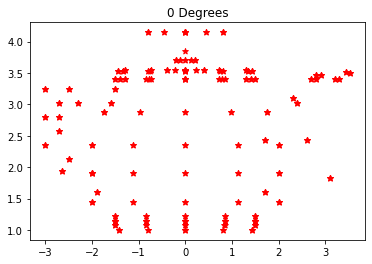

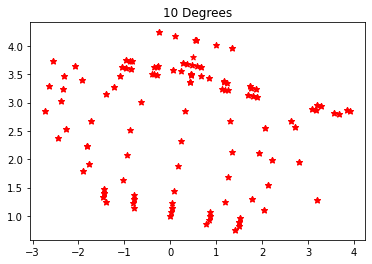

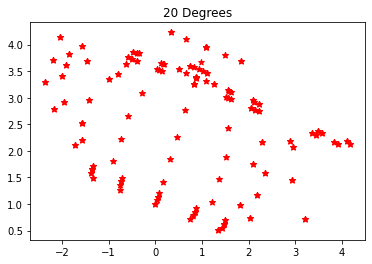

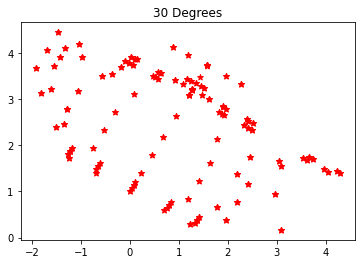

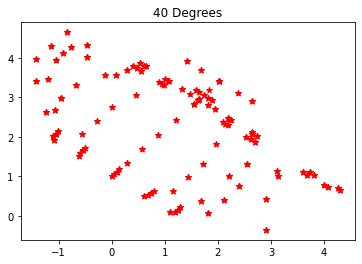

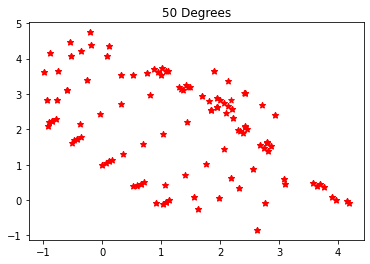

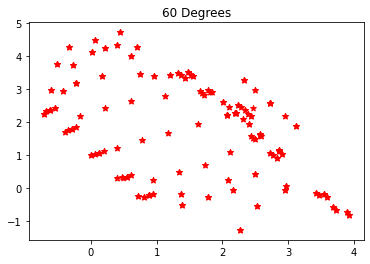

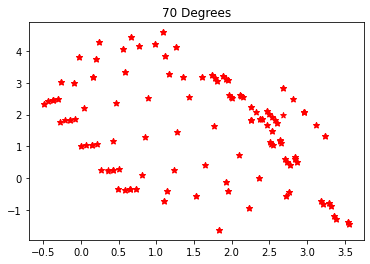

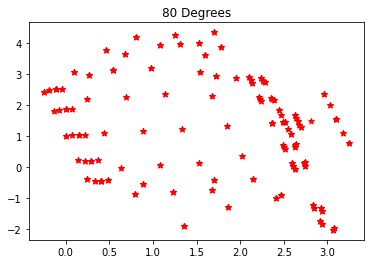

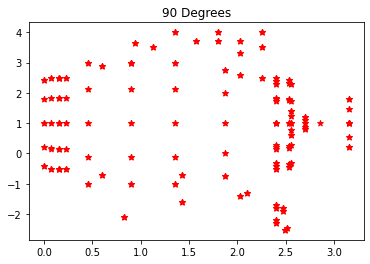

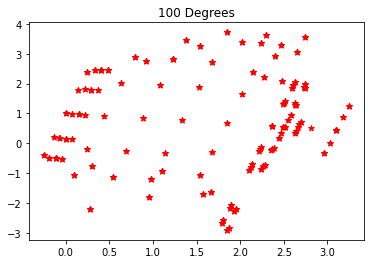

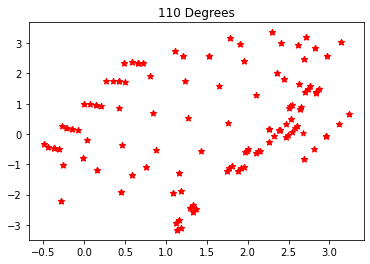

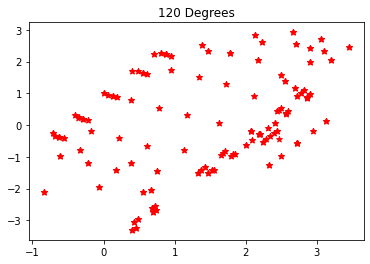

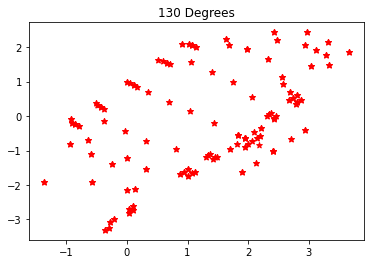

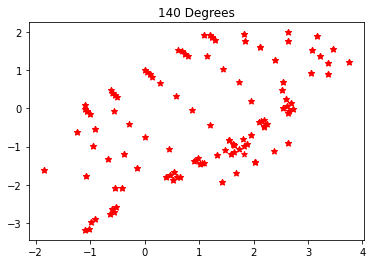

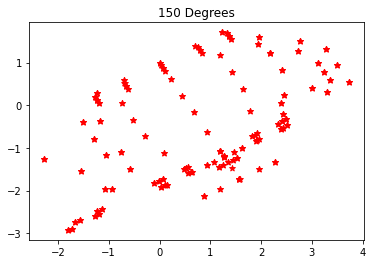

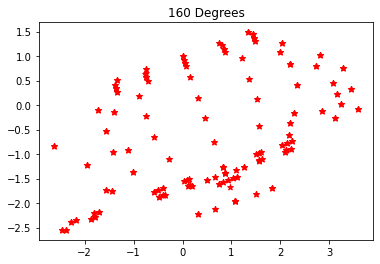

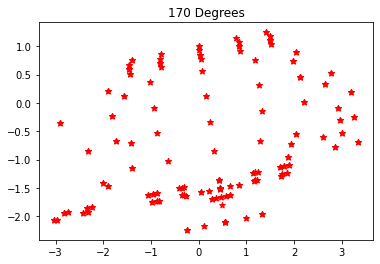

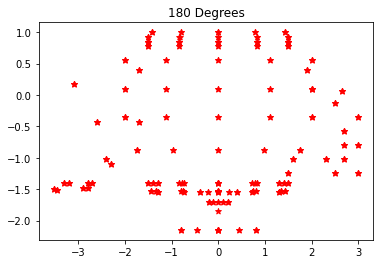

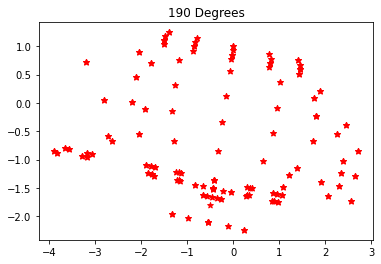

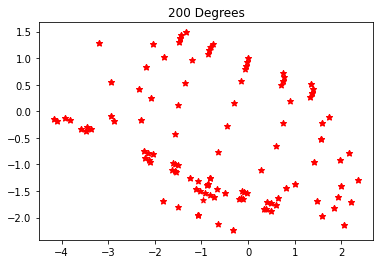

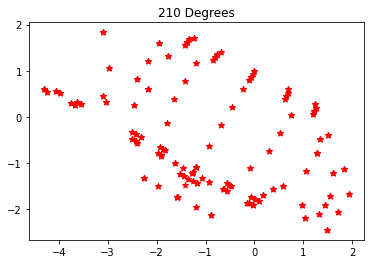

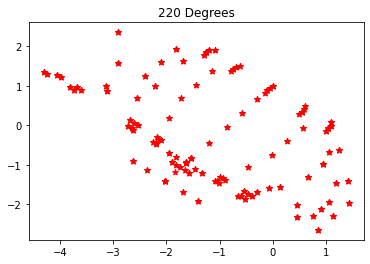

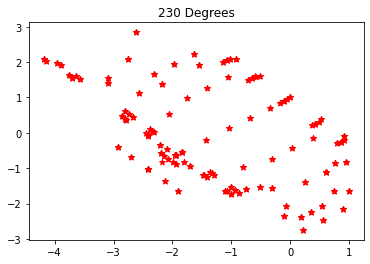

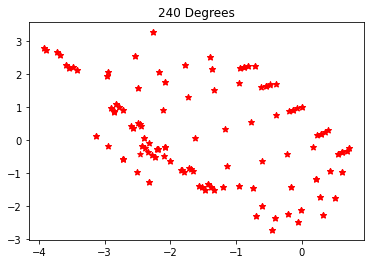

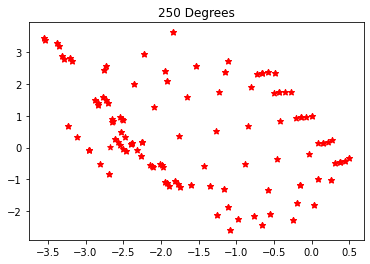

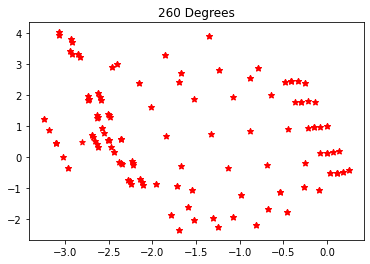

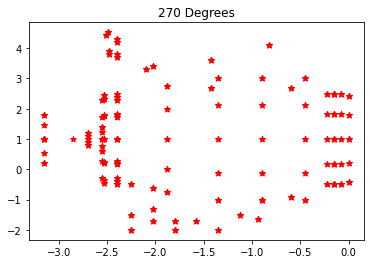

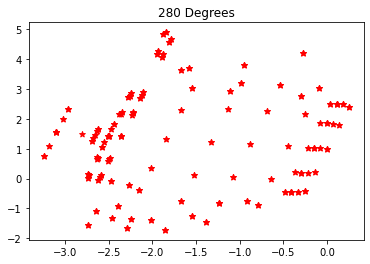

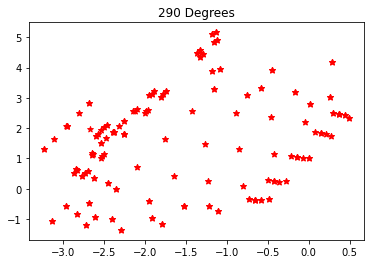

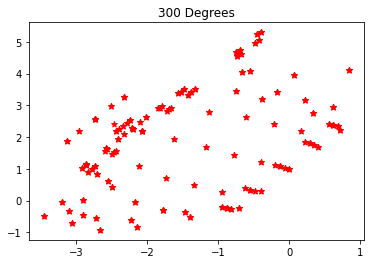

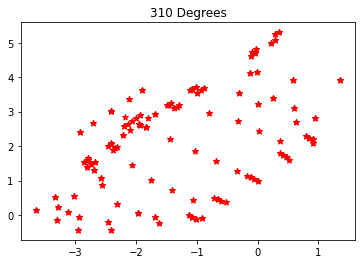

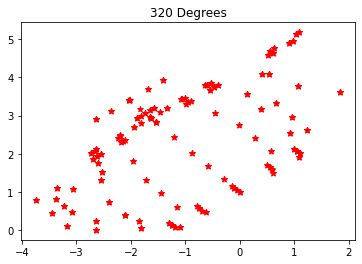

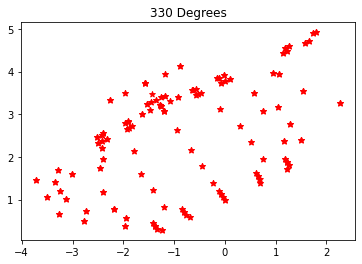

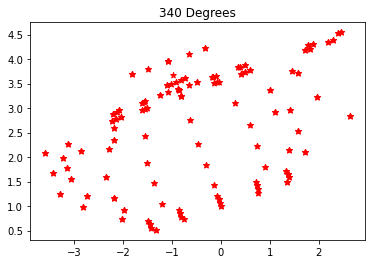

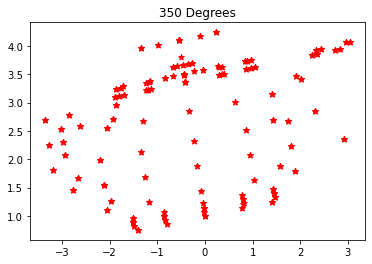

In [44]:
### Your implementation comes here
# Hint: new2Dpts = K[R|T]*3DPoints

homogeneous_coords = np.ones((len(a)))
threeDPoints = np.array([a, b, c, homogeneous_coords]) # [a, b, c, 1]

K = np.array([
    [1,0,0], 
    [0,0,1]
])

angle = 0 

new2Dpts = []

def threeD_2_twoD(threeD, angle, K):
    twoD = np.matmul(K, np.matmul(rotation_matrix_y(angle), threeD))
    
    new2Dpts.append([twoD[0], twoD[1]])
    
    # Just for visualizing my camera taken images
    
    fig = plt.figure()
    tp = fig.add_subplot(111)
    tp.scatter(twoD[0],twoD[1], c='r', marker='*')
    tp.set_title(str(angle) + " Degrees")
    
    return

i = 0
while i < 36:
    threeD_2_twoD(threeDPoints, angle, K)
    angle = angle + 10
    i = i + 1

### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [45]:
def rows_helper(m1, m2, u):
    i = 0
    length = len(u)
    while i < length:
        r = u[i:i+2]
        
        m1.append([r[0][0]*r[0][0] , 2*r[0][0]*r[0][1] , 2*r[0][0]*r[0][2], r[0][1]*r[0][1] ,2*r[0][1]*r[0][2], r[0][2]*r[0][2]])
        m1.append([r[0][0]*r[1][0] , ((r[0][1]*r[1][0]) + (r[0][2]*r[1][1]) ), ((r[0][2]*r[1][0])+ (r[0][0]*r[1][2])), r[0][1]*r[1][1] ,((r[0][2]*r[1][1])+(r[0][1]*r[1][2])), r[0][2]*r[1][2]])
        m1.append([r[1][0]*r[1][0], 2*r[1][0]*r[1][1] , 2*r[1][0]*r[1][2], r[1][1]*r[1][1] ,2*r[1][1]*r[1][2], r[1][2]*r[1][2]])

        m2.append(1)
        m2.append(0)
        m2.append(1)

        i = i + 2
        
    return m1, m2  

In [46]:
def helper1(m1, m2):
    m1 = np.array(m1)
    m1_inverse = np.linalg.inv(np.matmul(np.array(m1).T, m1))

    Q1 = np.matmul(m1_inverse , np.matmul(np.array(m1).T , np.array(m2)))

    Q2 = np.zeros((3,3))
    
    return Q1, Q2

In [47]:
def helper2(Q1, Q2):
    iterator = 3
    for i in range(iterator):
        for j in range(iterator):
            if i != 0:
                if j != 0:
                    Q2[i][j] = Q1[i + j + 1]
                else:
                     Q2[i][j] = Q1[i]
            else:
                Q2[i][j] = Q1[i + j]
        
    Q = np.linalg.cholesky(Q2)
    return Q

In [48]:
def get_identity(s):
    I = np.identity(3)
    I[0][0] = s[0]
    I[1][1] = s[1]
    I[2][2] = s[2]
    s = I
    return s

In [49]:
### Your implementation for Tomasi Kanade Factorization method comes here

W = np.zeros((72,306)) # 2F x P

center = 0

for i in new2Dpts:
    W[center] = i[0]
    W[center + 1] = i[1]
    center = center + 2

print('W Matrix')
print('')   
print(W)
print('')

# Tomasi Kanade Factorization method implementation

u, s, vh = np.linalg.svd(W)
u = u[0:,0:3]
vh = vh[0:3,0:]
s = s[0:3,]
m1 = []
m2 = []
m1, m2 = rows_helper(m1, m2, u)
Q1, Q2 = helper1(m1, m2)
Q = helper2(Q1, Q2)
s = get_identity(s)
s_hat  = np.matmul(s, vh)
Q_inverse = np.linalg.inv(Q)
sfm = np.matmul(Q_inverse , s_hat)

a1 = sfm[0,0:]
b1 = sfm[1,0:]
c1 = sfm[2,0:]

W Matrix

[[1.4        1.4        0.784      ... 1.5        0.798      1.425     ]
 [3.4        3.4        3.4        ... 1.075      1.         1.        ]
 [1.79548648 1.79548648 1.1888449  ... 1.49023524 0.78587659 1.40335105]
 ...
 [3.73409049 3.73409049 3.52340608 ... 1.58350716 1.27293207 1.4873787 ]
 [0.96197523 0.96197523 0.35533365 ... 1.46418802 0.78587659 1.40335105]
 [3.60664606 3.60664606 3.49967878 ... 1.33433285 1.13857125 1.24744865]]



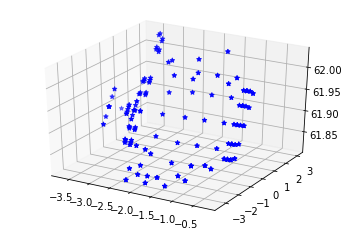

In [50]:
## Plot the reconstructed mode

# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the reconstructed 3D points are 
# in variables a1, b1 and c1 respectively, the reconstructed model can be plotted as:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='b', marker='*')

In [54]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:

err = 0.0
j = 0
for i in range(len(a1)):
  err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) ) * 0 +7
  j=j+1
  
print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  7.0
